# EDA-undersampling
对tf-idf中表现较好的几个模型使用eda加undersampling的方法进行优化，增加样本数，减少样本不均的问题。

## 方法定义

In [2]:

import numpy as np
import os
import nltk

import torch
import torch.nn
import torchtext.vocab as vocab
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
import pandas as pd
import warnings
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore")

In [3]:
def load_data():
    column = ['name', 'cat']
    df = pd.read_csv("../data_cleaning/eda_data_augmented.csv", encoding='utf_8_sig', usecols=column)
    # df = df[:5000]
    # print(df.columns)
    #df.drop(df[df.cat== 'Seafood'].index, inplace= True )
    df.columns = ['name', 'cat']
    texts = df['name'].values
    df = df.fillna(-1)
    # labels = np.argmax(df[df.columns[-4:]].values, axis=1)
    labels = df['cat'].values
    label2id = {l: i for i, l in enumerate(set(labels))}
    id2label = {i: l for l, i in label2id.items()}
    labels = [label2id[l] for l in labels]
    return texts, labels, id2label

In [4]:
def text_preprocess(text):
    text = str(text)
    english_punctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%', '\'', '/']
    text = "".join([(a if a not in english_punctuations else " ") for a in text])
    text = " ".join(nltk.tokenize.word_tokenize(text.lower()))
    return text

In [5]:
def evaluation(predictions, labels, id2label, model_name=None):
    acc = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, average="macro")
    f1 = f1_score(labels, predictions, average="macro")
    report = metrics.classification_report(labels, predictions,
                                           target_names=[id2label[i] for i in range(len(id2label))])
    info = "acc:%s, recall:%s, f1 score:%s" % (acc, recall, f1)
    if model_name is not None:
        info = "%s: %s" % (model_name, info)
    print(info)
    print(report)

## 数据处理

In [6]:
texts, labels, id2label = load_data()  
texts = [text_preprocess(t) for t in texts]

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer 
vectorizer = TfidfVectorizer() 
features=vectorizer.fit_transform(texts)
print("data len:", len(texts))
print("id2label",id2label)

data len: 368223
id2label {0: 'Pantry', 1: 'Pets', 2: 'Fresh Foods & Bakery', 3: 'Drinks', 4: 'Kitchen, Dining & Household', 5: 'Chilled, Frozen & Desserts', 6: 'Beer, Cider & Wine', 7: 'Personal Care', 8: 'Baby, Toddler & Kids'}


In [8]:
features

<368223x20657 sparse matrix of type '<class 'numpy.float64'>'
	with 2195577 stored elements in Compressed Sparse Row format>

In [9]:
from imblearn.under_sampling import RandomUnderSampler
# 使用RandomUnderSampler方法进行欠抽样处理
def under_sampling(x,y):
    model_RandomUnderSampler = RandomUnderSampler() # 建立RandomUnderSampler模型对象
    x_RandomUnderSampler_resampled, y_RandomUnderSampler_resampled =model_RandomUnderSampler.fit_sample(x,y) # 输入数据并作欠抽样处理
    return x_RandomUnderSampler_resampled, y_RandomUnderSampler_resampled


x,y = under_sampling(features,labels)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=3)


In [17]:
x

<78120x20657 sparse matrix of type '<class 'numpy.float64'>'
	with 486437 stored elements in Compressed Sparse Row format>

In [16]:
x_test

<19530x20657 sparse matrix of type '<class 'numpy.float64'>'
	with 122000 stored elements in Compressed Sparse Row format>

## 模型优化

In [10]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

KNN

k is 5


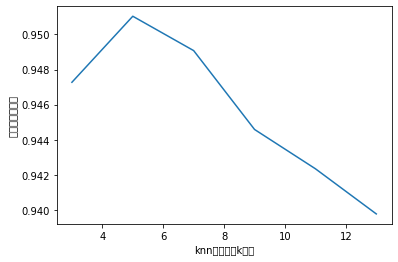

In [19]:
from sklearn.model_selection import cross_val_score
k_range=[3,5,7,9,11,13]
k_score=[]
max=0
index=0
for i in k_range:
    knn = KNeighborsClassifier(n_neighbors=i)
    score=cross_val_score(knn,x,y,cv=5,scoring='accuracy')
    if score.mean() > max:
        max = score.mean()
        index = i
    k_score.append(score.mean())

print('k is %d' %index)
plt.plot(k_range,k_score)
plt.xlabel('knn中近邻数k的值')
plt.ylabel('交叉验证精确度')
plt.show()


In [15]:
#KNN
model = KNeighborsClassifier(n_neighbors=9)
model.fit(x_train, y_train)
knn_predict_labels = model.predict(x_test)
evaluation(knn_predict_labels, y_test, id2label, "knn")

knn: acc:0.9455709165386584, recall:0.9451106801156476, f1 score:0.9447557897332778
                             precision    recall  f1-score   support

 Chilled, Frozen & Desserts       0.88      0.96      0.92      2154
       Fresh Foods & Bakery       0.90      0.91      0.91      2134
         Beer, Cider & Wine       0.97      0.97      0.97      2158
                     Pantry       0.94      0.82      0.88      2134
                     Drinks       0.96      0.99      0.97      2244
                       Pets       0.97      1.00      0.98      2172
Kitchen, Dining & Household       0.97      0.93      0.95      2166
       Baby, Toddler & Kids       0.95      0.99      0.97      2180
              Personal Care       0.97      0.93      0.95      2188

                   accuracy                           0.95     19530
                  macro avg       0.95      0.95      0.94     19530
               weighted avg       0.95      0.95      0.95     19530



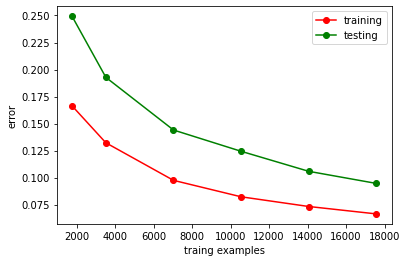

In [21]:
knn = KNeighborsClassifier(n_neighbors=9)
train_sizes,train_score,test_score = learning_curve(knn,x_test,y_test,train_sizes=[0.1,0.2,0.4,0.6,0.8,1],cv=10,scoring='accuracy')
train_error =  1- np.mean(train_score,axis=1)
test_error = 1- np.mean(test_score,axis=1)
plt.plot(train_sizes,train_error,'o-',color = 'r',label = 'training')
plt.plot(train_sizes,test_error,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('traing examples')
plt.ylabel('error')
plt.show()

## SVM

In [20]:
# undersampled
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
model = OneVsRestClassifier(SVC(C=1000, gamma=0.001, kernel='rbf'))
model.fit(x_train, y_train) 
svm_predict_labels = model.predict(x_test)
evaluation(svm_predict_labels, y_test, id2label, "svm")

svm: acc:0.9770609318996416, recall:0.9768444480668137, f1 score:0.9768487236951593
                             precision    recall  f1-score   support

 Chilled, Frozen & Desserts       0.96      0.97      0.96      2154
       Fresh Foods & Bakery       0.96      0.95      0.95      2134
         Beer, Cider & Wine       1.00      0.99      0.99      2158
                     Pantry       0.94      0.93      0.94      2134
                     Drinks       0.98      1.00      0.99      2244
                       Pets       1.00      0.99      1.00      2172
Kitchen, Dining & Household       0.98      0.99      0.98      2166
       Baby, Toddler & Kids       0.99      1.00      1.00      2180
              Personal Care       0.98      0.97      0.98      2188

                   accuracy                           0.98     19530
                  macro avg       0.98      0.98      0.98     19530
               weighted avg       0.98      0.98      0.98     19530



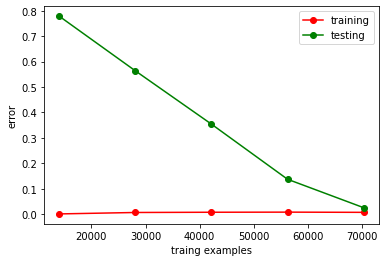

In [11]:
from sklearn.svm import SVC
train_sizes,train_score,test_score = learning_curve(SVC(C=1000, gamma=0.001, kernel='rbf'),x,y,train_sizes=[0.1,0.2,0.4,0.6,0.8,1],cv=10,scoring='accuracy')
train_error =  1- np.mean(train_score,axis=1)
test_error = 1- np.mean(test_score,axis=1)
plt.plot(train_sizes,train_error,'o-',color = 'r',label = 'training')
plt.plot(train_sizes,test_error,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('traing examples')
plt.ylabel('error')
plt.show()
